In [59]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
from altair_data_server import data_server
alt.data_transformers.enable('vegafusion')

DataTransformerRegistry.enable('vegafusion')

In [60]:
# import datasets
sensorA_System1 = pd.read_csv("../../../RawData/System1_SensorA.csv")
sensorA_System2 = pd.read_csv("../../../RawData/System2_SensorA.csv")
sensorB_System1 = pd.read_csv("../../../RawData/System1_SensorB.csv")
sensorB_System2 = pd.read_csv("../../../RawData/System2_SensorB.csv")
sensorA_System1_missing = pd.read_csv("../../../RawData/SensorA_System1_missing values.csv")
sensorA_System2_missing = pd.read_csv("../../../RawData/SensorA_System2_missing values.csv")
keyByTestID = pd.read_csv("../../../RawData/Key by TestID.csv")

In [61]:
# Transpose dataset to make columns as timestamps and rows as tests
A1_transposed = sensorA_System1.T.reset_index()
A1_transposed.columns = A1_transposed.iloc[0]
A1_transposed.rename(columns={A1_transposed.columns[0]: 'TestID'}, inplace=True)
A1_transposed = A1_transposed.drop(0)
A1_transposed['TestID'] = A1_transposed['TestID'].astype(int)

A2_transposed = sensorA_System2.T.reset_index()
A2_transposed.columns = A2_transposed.iloc[0]
A2_transposed.rename(columns={A2_transposed.columns[0]: 'TestID'}, inplace=True)
A2_transposed = A2_transposed.drop(0)
A2_transposed['TestID'] = A2_transposed['TestID'].astype(int)

A1_missing_transposed = sensorA_System1_missing.T.reset_index()
A1_missing_transposed.columns = A1_missing_transposed.iloc[0]
A1_missing_transposed.rename(columns={A1_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A1_missing_transposed = A1_missing_transposed.drop(0)
A1_missing_transposed['TestID'] = A1_missing_transposed['TestID'].astype(int)

A2_missing_transposed = sensorA_System2_missing.T.reset_index()
A2_missing_transposed.columns = A2_missing_transposed.iloc[0]
A2_missing_transposed.rename(columns={A2_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A2_missing_transposed = A2_missing_transposed.drop(0)
A2_missing_transposed['TestID'] = A2_missing_transposed['TestID'].astype(int)

B1_transposed = sensorB_System1.T.reset_index()
B1_transposed.columns = B1_transposed.iloc[0]
B1_transposed.rename(columns={B1_transposed.columns[0]: 'TestID'}, inplace=True)
B1_transposed = B1_transposed.drop(0)
B1_transposed['TestID'] = B1_transposed['TestID'].astype(int)

B2_transposed = sensorB_System2.T.reset_index()
B2_transposed.columns = B2_transposed.iloc[0]
B2_transposed.rename(columns={B2_transposed.columns[0]: 'TestID'}, inplace=True)
B2_transposed = B2_transposed.drop(0)
B2_transposed['TestID'] = B2_transposed['TestID'].astype(int)

In [62]:
# Complete A1 and A2 with the missing values
A1_transposed_mid = A1_transposed[~A1_transposed.TestID.isin(A1_missing_transposed.TestID)]
A1_transposed = pd.concat([A1_transposed_mid, A1_missing_transposed], axis=0)
A2_transposed_mid = A2_transposed[~A2_transposed.TestID.isin(A2_missing_transposed.TestID)]
A2_transposed = pd.concat([A2_transposed_mid, A2_missing_transposed], axis=0)

In [63]:
# Merge dataset with keyByTestID and delete unmatched tests
keyByTestID['TestID'] = keyByTestID['TestID'].astype(int)
keyByTestID['System'] = keyByTestID['System'].astype(str)
keyByTestID = keyByTestID[keyByTestID['ReturnCode'].isin(['Success','UnderReportableRange'])]

A1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] == 'System 1')]
A1_Merged = pd.merge(A1_keyByTestID,A1_transposed,how='inner', on=['TestID'])
A1_transposed = A1_transposed[A1_transposed['TestID'].isin(A1_Merged['TestID'])]

A2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] != 'System 1')]
A2_Merged = pd.merge(A2_keyByTestID,A2_transposed,how='inner', on=['TestID'])
A2_transposed = A2_transposed[A2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorA_System1 = sensorA_System1.loc[:, sensorA_System1.columns.isin(A1_Merged['TestID'].astype(str))]
sensorA_System2 = sensorA_System2.loc[:, sensorA_System2.columns.isin(A2_Merged['TestID'].astype(str))]


B1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] == 'System 1')]
B1_Merged = pd.merge(B1_keyByTestID,B1_transposed,how='inner', on=['TestID'])
B1_transposed = B1_transposed[B1_transposed['TestID'].isin(B1_Merged['TestID'])]

B2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] != 'System 1')]
B2_Merged = pd.merge(B2_keyByTestID,B2_transposed,how='inner', on=['TestID'])
B1_transposed = B2_transposed[B2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorB_System1 = sensorB_System1.loc[:, sensorB_System1.columns.isin(B1_Merged['TestID'].astype(str))]
sensorB_System2 = sensorB_System2.loc[:, sensorB_System2.columns.isin(B2_Merged['TestID'].astype(str))]

In [64]:
# Match window values of Sensor A for each test
calDelimit = 11
cal_window_size = 8
sampleDelimit = 15
sample_window_size = 5

# Define a function to calculate window start and end values
def calculate_window_values(bubble_start, sample_start, calDelimit, cal_window_size, sampleDelimit, sample_window_size):
    cal_window_start = bubble_start - calDelimit
    cal_window_end = cal_window_start + cal_window_size
    sample_window_start = sample_start + sampleDelimit
    sample_window_end = sample_window_start + sample_window_size
    return round(cal_window_start,1), round(cal_window_end,1), round(sample_window_start,1), round(sample_window_end,1)

# For sensor A in system 1
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start = A1_Merged['BubbleDetectTime'],
                                                                                                   sample_start = A1_Merged['SampleDetectTime'],
                                                                                                   calDelimit = calDelimit,
                                                                                                   cal_window_size = cal_window_size,
                                                                                                   sampleDelimit = sampleDelimit,
                                                                                                   sample_window_size = sample_window_size
                                                                                                   )
A1_Merged['cal_window_start']=cal_window_start
A1_Merged['cal_window_end']=cal_window_end
A1_Merged['sample_window_start']=sample_window_start
A1_Merged['sample_window_end']=sample_window_end

# For sensor A in system 2
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_Merged['SampleDetectTime'],
                                                                                                   calDelimit = calDelimit,
                                                                                                   cal_window_size = cal_window_size,
                                                                                                   sampleDelimit = sampleDelimit,
                                                                                                   sample_window_size = sample_window_size)
A2_Merged['cal_window_start']=cal_window_start
A2_Merged['cal_window_end']=cal_window_end
A2_Merged['sample_window_start']=sample_window_start
A2_Merged['sample_window_end']=sample_window_end

In [65]:
# Match window values of Sensor B for each test
calDelimit = 20
cal_window_size = 18
sampleDelimit_blood = 24
sampleDelimit_aqueous = 30
sample_window_size = 4

# For sensor B in system 1, blood and aqueous
B1_Merged['cal_window_start'], B1_Merged['cal_window_end'], \
B1_Merged['sample_window_start'], B1_Merged['sample_window_end'] = zip(*B1_Merged.apply(
    lambda row: calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit=calDelimit,
        cal_window_size=cal_window_size,
        sampleDelimit=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit_blood,
        sample_window_size=sample_window_size
    ),
    axis=1
))

# For sensor B in system 2, blood and aqueous
B2_Merged['cal_window_start'], B2_Merged['cal_window_end'], \
B2_Merged['sample_window_start'], B2_Merged['sample_window_end'] = zip(*B2_Merged.apply(
    lambda row: calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit=calDelimit,
        cal_window_size=cal_window_size,
        sampleDelimit=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit_blood,
        sample_window_size=sample_window_size
    ),
    axis=1
))

In [66]:
# Define a function to extract window data of each test
def calculate_window_data(row):
    cal_start_time = row['cal_window_start']
    cal_end_time = row['cal_window_end']
    sample_start_time = row['sample_window_start']
    sample_end_time = row['sample_window_end']
    timestamps = row.index[18:-4].values.astype(float)
    cal_window = timestamps[(timestamps >= cal_start_time) & (timestamps <= cal_end_time)]
    sample_window = timestamps[(timestamps >= sample_start_time) & (timestamps <= sample_end_time)]
    return row[cal_window],row[sample_window]

# extract window data for sensor A in system 1
A1_cal_window = []
A1_sample_window = []
for i in range(len(A1_Merged)):
    cal_window, sample_window = calculate_window_data(A1_Merged.iloc[i, :])
    A1_cal_window.append(cal_window.values)
    A1_sample_window.append(sample_window.values)
A1_cal_window = pd.DataFrame(A1_cal_window)
A1_sample_window = pd.DataFrame(A1_sample_window)
A1_cal_window['TestID'] = A1_sample_window['TestID'] = A1_Merged['TestID']
A1_sample_window.set_index('TestID',inplace=True)
A1_cal_window.set_index('TestID',inplace=True)
A1_cal_window.dropna(inplace=True)
A1_sample_window.dropna(inplace=True)

# extract window data for sensor A in system 2
A2_cal_window = []
A2_sample_window = []
for i in range(len(A2_Merged)):
    cal_window, sample_window = calculate_window_data(A2_Merged.iloc[i, :])
    A2_cal_window.append(cal_window.values)
    A2_sample_window.append(sample_window.values)
A2_cal_window = pd.DataFrame(A2_cal_window)
A2_sample_window = pd.DataFrame(A2_sample_window)
A2_cal_window['TestID'] = A2_sample_window['TestID'] = A2_Merged['TestID']
A2_sample_window.set_index('TestID',inplace=True)
A2_cal_window.set_index('TestID',inplace=True)
A2_cal_window.dropna(inplace=True)
A2_sample_window.dropna(inplace=True)

# extract window data for sensor B in system 1
B1_cal_window = []
B1_sample_window = []
for i in range(len(B1_Merged)):
    cal_window, sample_window = calculate_window_data(B1_Merged.iloc[i, :])
    B1_cal_window.append(cal_window.values)
    B1_sample_window.append(sample_window.values)
B1_cal_window = pd.DataFrame(B1_cal_window)
B1_sample_window = pd.DataFrame(B1_sample_window)
B1_cal_window['TestID'] = B1_sample_window['TestID'] = B1_Merged['TestID']
B1_sample_window.set_index('TestID',inplace=True)
B1_cal_window.set_index('TestID',inplace=True)
B1_cal_window.dropna(inplace=True)
B1_sample_window.dropna(inplace=True)

# extract window data for sensor B in system 2
B2_cal_window = []
B2_sample_window = []
for i in range(len(B2_Merged)):
    cal_window, sample_window = calculate_window_data(B2_Merged.iloc[i, :])
    B2_cal_window.append(cal_window.values)
    B2_sample_window.append(sample_window.values)
B2_cal_window = pd.DataFrame(B2_cal_window)
B2_sample_window = pd.DataFrame(B2_sample_window)
B2_cal_window['TestID'] = B2_sample_window['TestID'] = B2_Merged['TestID']
B2_sample_window.set_index('TestID',inplace=True)
B2_cal_window.set_index('TestID',inplace=True)
B2_cal_window.dropna(inplace=True)
B2_sample_window.dropna(inplace=True)


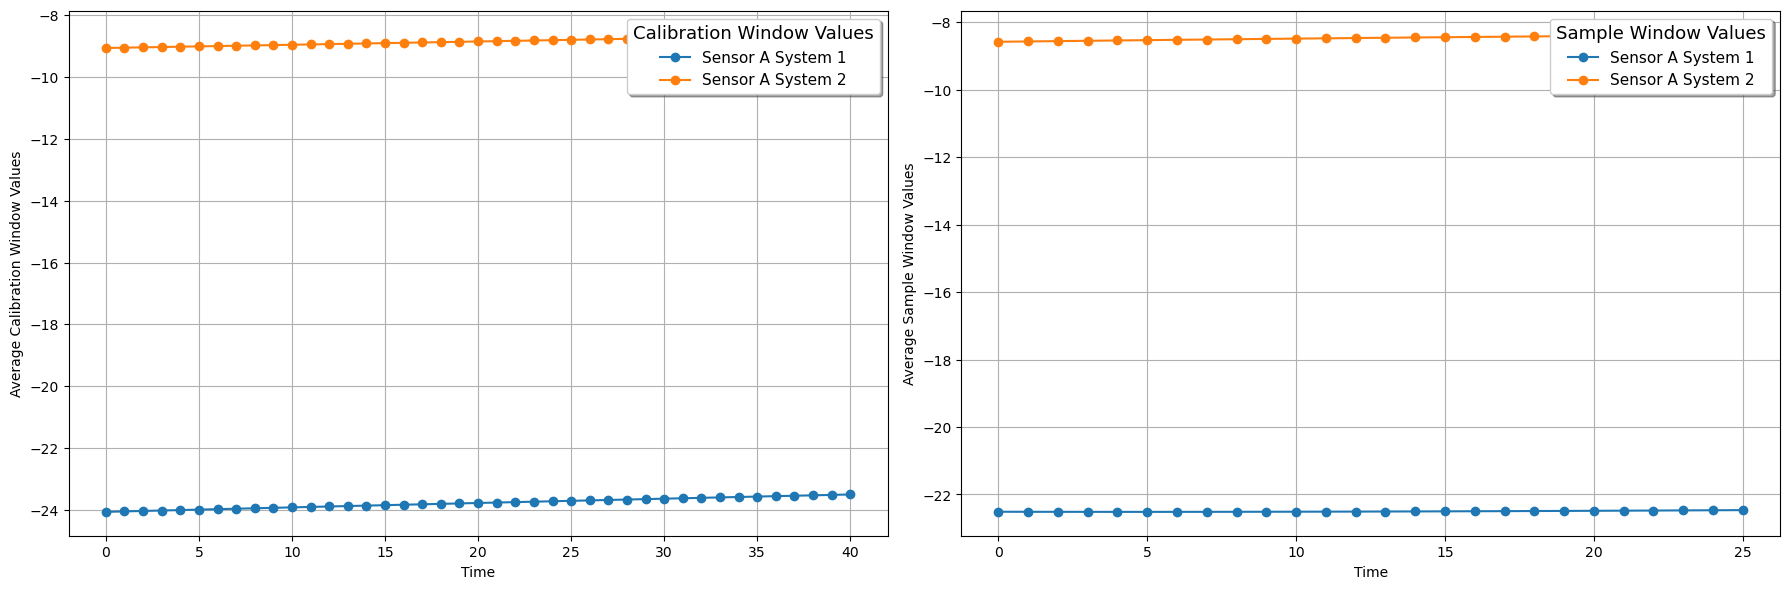

In [67]:
# Plot the window for sensor A
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot the first window for sensor A
axs[0].plot(A1_cal_window.columns, A1_cal_window.mean(), marker='o', linestyle='-', label='Sensor A System 1')
# axs[0].fill_between(A1_cal_window.columns.to_numpy(), A1_cal_window.mean() - A1_cal_window.std(), A1_cal_window.mean() - A1_cal_window.std(), color='blue', alpha=0.3)
axs[0].plot(A2_cal_window.columns, A2_cal_window.mean(), marker='o', linestyle='-', label='Sensor A System 2')
# axs[0].fill_between(A2_cal_window.columns.to_numpy(), A2_cal_window.mean() - A2_cal_window.std(), A2_cal_window.mean() + A2_cal_window.std(), color='red', alpha=0.3)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Average Calibration Window Values')
axs[0].legend(title='Calibration Window Values', title_fontsize='13', fontsize='11', loc='upper right', frameon=True, shadow=True, fancybox=True)
axs[0].grid(True)

# Plot the second window for sensor A
axs[1].plot(A1_sample_window.columns, A1_sample_window.mean(), marker='o', linestyle='-', label='Sensor A System 1')
axs[1].plot(A2_sample_window.columns, A2_sample_window.mean(), marker='o', linestyle='-', label='Sensor A System 2')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Average Sample Window Values')
axs[1].legend(title='Sample Window Values', title_fontsize='13', fontsize='11', loc='upper right', frameon=True, shadow=True, fancybox=True)
axs[1].grid(True)

plt.tight_layout()
plt.show()


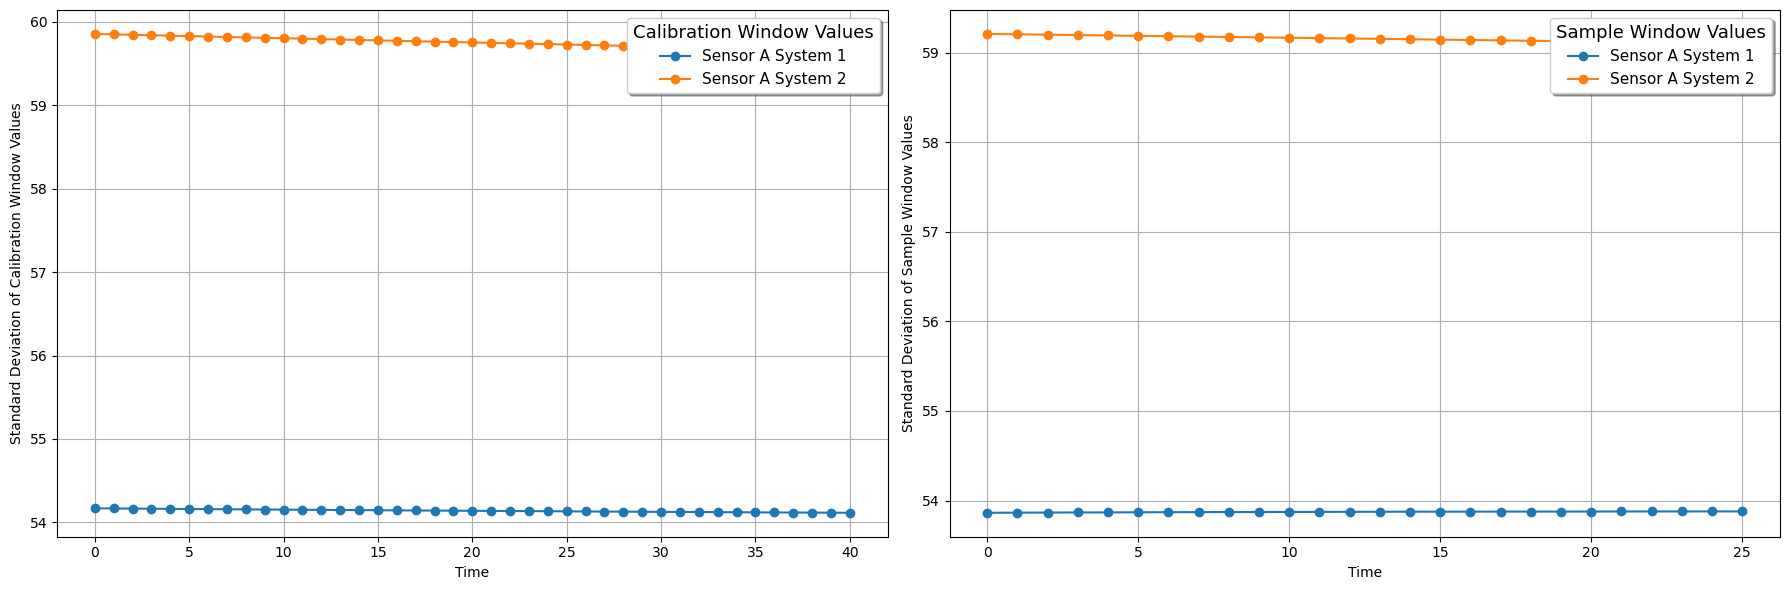

In [68]:
# Plot the window for sensor A
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot the first window for sensor A
axs[0].plot(A1_cal_window.columns, A1_cal_window.std(), marker='o', linestyle='-', label='Sensor A System 1')
axs[0].plot(A2_cal_window.columns, A2_cal_window.std(), marker='o', linestyle='-', label='Sensor A System 2')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Standard Deviation of Calibration Window Values')
axs[0].legend(title='Calibration Window Values', title_fontsize='13', fontsize='11', loc='upper right', frameon=True, shadow=True, fancybox=True)
axs[0].grid(True)

# Plot the second window for sensor A
axs[1].plot(A1_sample_window.columns, A1_sample_window.std(), marker='o', linestyle='-', label='Sensor A System 1')
axs[1].plot(A2_sample_window.columns, A2_sample_window.std(), marker='o', linestyle='-', label='Sensor A System 2')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Standard Deviation of Sample Window Values')
axs[1].legend(title='Sample Window Values', title_fontsize='13', fontsize='11', loc='upper right', frameon=True, shadow=True, fancybox=True)
axs[1].grid(True)

plt.tight_layout()
plt.show()

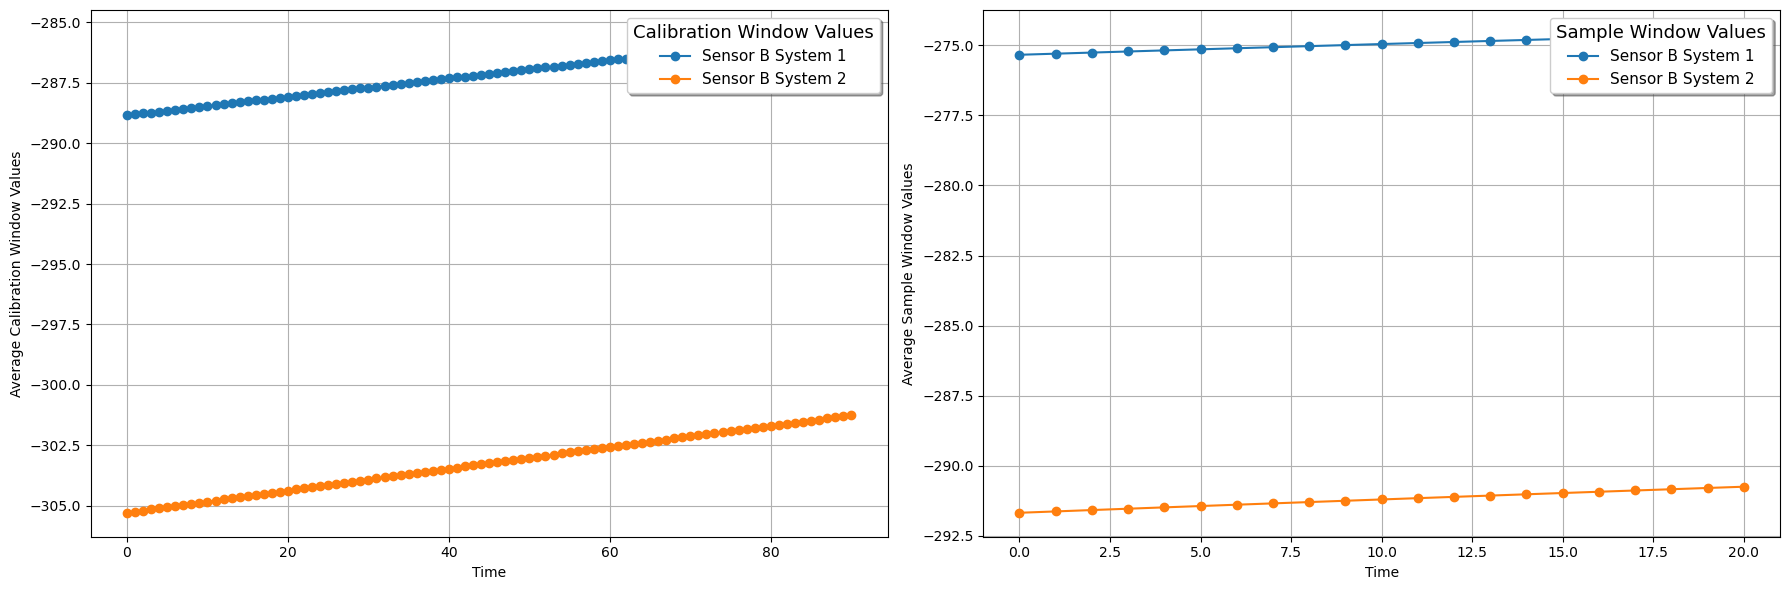

In [69]:
# Plot the window for sensor B
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot the first window for sensor B
axs[0].plot(B1_cal_window.columns, B1_cal_window.mean(), marker='o', linestyle='-', label='Sensor B System 1')
axs[0].plot(B2_cal_window.columns, B2_cal_window.mean(), marker='o', linestyle='-', label='Sensor B System 2')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Average Calibration Window Values')
axs[0].legend(title='Calibration Window Values', title_fontsize='13', fontsize='11', loc='upper right', frameon=True, shadow=True, fancybox=True)
axs[0].grid(True)

# Plot the second window for sensor B
axs[1].plot(B1_sample_window.columns, B1_sample_window.mean(), marker='o', linestyle='-', label='Sensor B System 1')
axs[1].plot(B2_sample_window.columns, B2_sample_window.mean(), marker='o', linestyle='-', label='Sensor B System 2')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Average Sample Window Values')
axs[1].legend(title='Sample Window Values', title_fontsize='13', fontsize='11', loc='upper right', frameon=True, shadow=True, fancybox=True)
axs[1].grid(True)

plt.tight_layout()
plt.show()

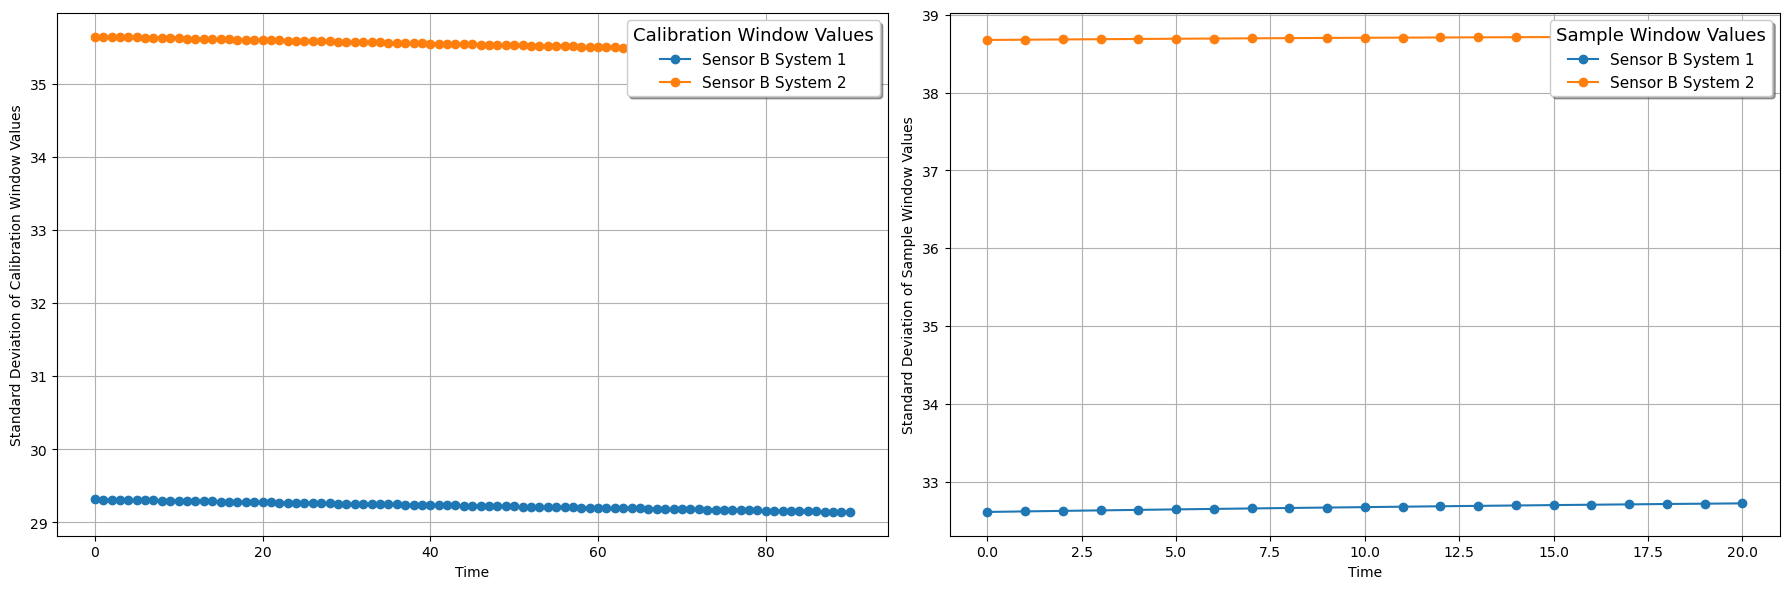

In [70]:
# Plot the window for sensor B
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot the first window for sensor B
axs[0].plot(B1_cal_window.columns, B1_cal_window.std(), marker='o', linestyle='-', label='Sensor B System 1')
axs[0].plot(B2_cal_window.columns, B2_cal_window.std(), marker='o', linestyle='-', label='Sensor B System 2')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Standard Deviation of Calibration Window Values')
axs[0].legend(title='Calibration Window Values', title_fontsize='13', fontsize='11', loc='upper right', frameon=True, shadow=True, fancybox=True)
axs[0].grid(True)

# Plot the second window for sensor B
axs[1].plot(B1_sample_window.columns, B1_sample_window.std(), marker='o', linestyle='-', label='Sensor B System 1')
axs[1].plot(B2_sample_window.columns, B2_sample_window.std(), marker='o', linestyle='-', label='Sensor B System 2')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Standard Deviation of Sample Window Values')
axs[1].legend(title='Sample Window Values', title_fontsize='13', fontsize='11', loc='upper right', frameon=True, shadow=True, fancybox=True)
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [71]:
# Calculate metrics of average window data for sensor A
cal_metrics=[[A1_cal_window.mean().mean(),A2_cal_window.mean().mean()],
            [A1_cal_window.mean().std(),A2_cal_window.mean().std()],
            [(A1_cal_window.mean().max()-A1_cal_window.mean().min())/A1_cal_window.mean().mean(),
            (A2_cal_window.mean().max()-A2_cal_window.mean().min())/A2_cal_window.mean().mean()]]
cal_metrics_summary = pd.DataFrame(cal_metrics, columns=['A1-cal','A2-cal'], index=['mean','sd','slope'])
print(cal_metrics_summary)
print()
sample_metrics=[[A1_sample_window.mean().mean(),A2_sample_window.mean().mean()],
            [A1_sample_window.mean().std(),A2_sample_window.mean().std()],
            [(A1_sample_window.mean().max()-A1_sample_window.mean().min())/A1_sample_window.mean().mean(),
            (A2_sample_window.mean().max()-A2_sample_window.mean().min())/A2_sample_window.mean().mean()]]
sample_metrics_summary = pd.DataFrame(sample_metrics, columns=['A1-sample','A2-sample'], index=['mean','sd','slope'])
print(sample_metrics_summary)

          A1-cal    A2-cal
mean  -23.770362 -8.855061
sd      0.168190  0.127767
slope  -0.023630 -0.048284

       A1-sample  A2-sample
mean  -22.499265  -8.463227
sd      0.016618   0.063780
slope  -0.002285  -0.024615


In [72]:
# Calculate metrics of average window data for sensor B
cal_metrics=[[B1_cal_window.mean().mean(),B2_cal_window.mean().mean()],
            [B1_cal_window.mean().std(),B2_cal_window.mean().std()],
            [(B1_cal_window.mean().max()-B1_cal_window.mean().min())/B1_cal_window.mean().mean(),
            (B2_cal_window.mean().max()-B2_cal_window.mean().min())/B2_cal_window.mean().mean()]]
cal_metrics_summary = pd.DataFrame(cal_metrics, columns=['B1-cal','B2-cal'], index=['mean','sd','slope'])
print(cal_metrics_summary)
print()
sample_metrics=[[B1_sample_window.mean().mean(),B2_sample_window.mean().mean()],
            [B1_sample_window.mean().std(),B2_sample_window.mean().std()],
            [(B1_sample_window.mean().max()-B1_sample_window.mean().min())/B1_sample_window.mean().mean(),
            (B2_sample_window.mean().max()-B2_sample_window.mean().min())/B2_sample_window.mean().mean()]]
sample_metrics_summary = pd.DataFrame(sample_metrics, columns=['B1-sample','B2-sample'], index=['mean','sd','slope'])
print(sample_metrics_summary)

           B1-cal      B2-cal
mean  -287.140933 -303.255256
sd       0.990252    1.183999
slope   -0.011728   -0.013298

        B1-sample   B2-sample
mean  -274.959814 -291.207365
sd       0.230525    0.288276
slope   -0.002703   -0.003192


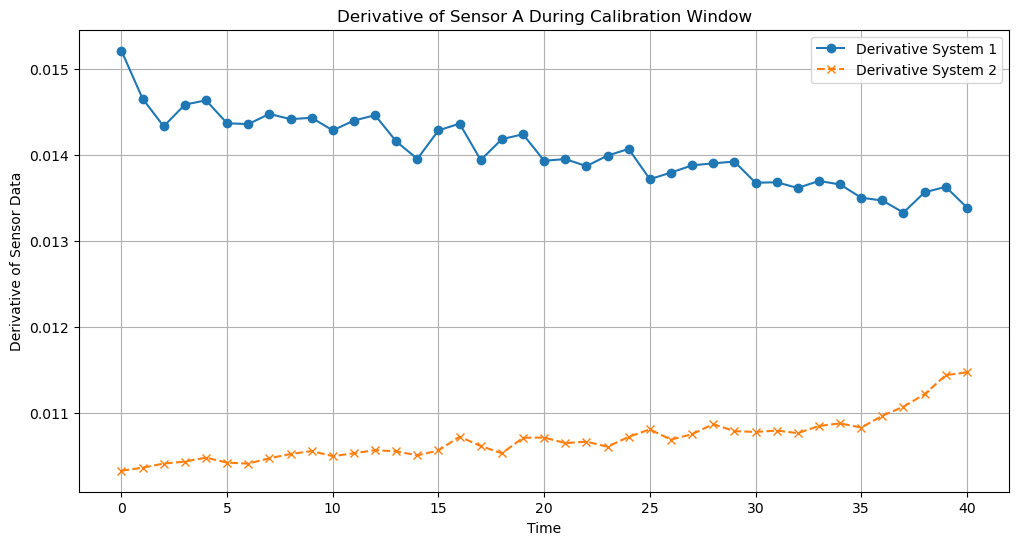

In [73]:
# Calibration window derivative trend for sensor A
# Calculate the derivative of sensor data
A1_cal_window_derivative = np.gradient(A1_cal_window.mean(), A1_cal_window.columns)
A2_cal_window_derivative = np.gradient(A2_cal_window.mean(), A2_cal_window.columns)

# Plotting the derivatives
plt.figure(figsize=(12, 6))
plt.plot(A1_cal_window_derivative, label='Derivative System 1', marker='o', linestyle='-')
plt.plot(A2_cal_window_derivative, label='Derivative System 2', marker='x', linestyle='--')

plt.title('Derivative of Sensor A During Calibration Window')
plt.xlabel('Time')
plt.ylabel('Derivative of Sensor Data')
plt.legend()
plt.grid(True)
plt.show()

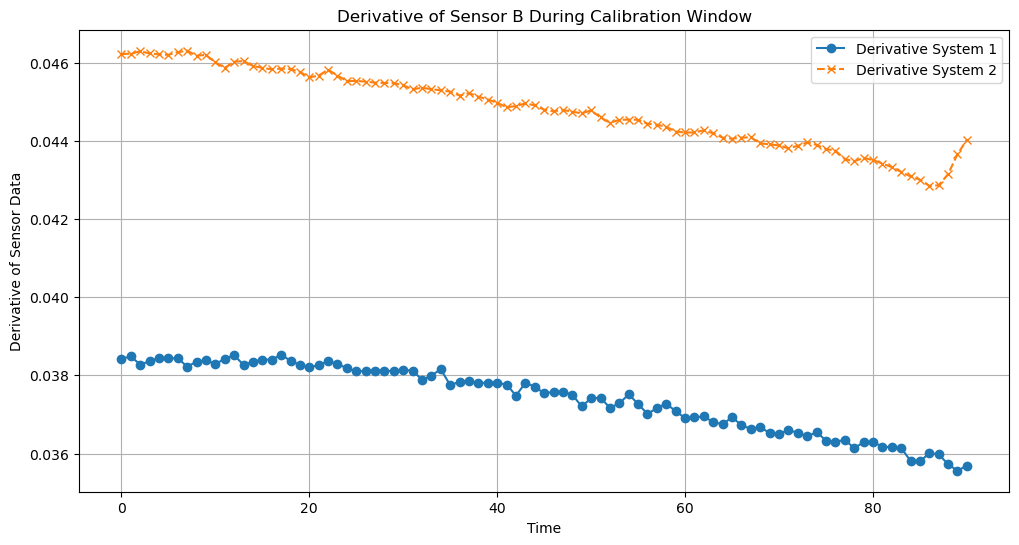

In [74]:
# Calibration window derivative trend for sensor B
# Calculate the derivative of sensor data
B1_cal_window_derivative = np.gradient(B1_cal_window.mean(), B1_cal_window.columns)
B2_cal_window_derivative = np.gradient(B2_cal_window.mean(), B2_cal_window.columns)

# Plotting the derivatives
plt.figure(figsize=(12, 6))
plt.plot(B1_cal_window_derivative, label='Derivative System 1', marker='o', linestyle='-')
plt.plot(B2_cal_window_derivative, label='Derivative System 2', marker='x', linestyle='--')

plt.title('Derivative of Sensor B During Calibration Window')
plt.xlabel('Time')
plt.ylabel('Derivative of Sensor Data')
plt.legend()
plt.grid(True)
plt.show()

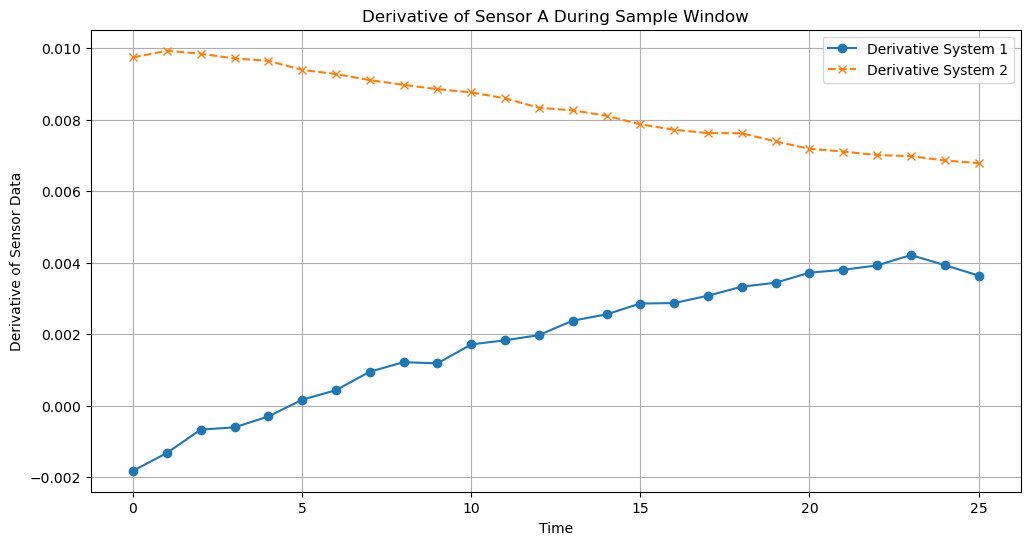

In [75]:
# Sample window derivative trend for sensor A
# Calculate the derivative of sensor data
A1_sample_window_derivative = np.gradient(A1_sample_window.mean(), A1_sample_window.columns)
A2_sample_window_derivative = np.gradient(A2_sample_window.mean(), A2_sample_window.columns)

# Plotting the derivatives
plt.figure(figsize=(12, 6))
plt.plot(A1_sample_window_derivative, label='Derivative System 1', marker='o', linestyle='-')
plt.plot(A2_sample_window_derivative, label='Derivative System 2', marker='x', linestyle='--')

plt.title('Derivative of Sensor A During Sample Window')
plt.xlabel('Time')
plt.ylabel('Derivative of Sensor Data')
plt.legend()
plt.grid(True)
plt.show()

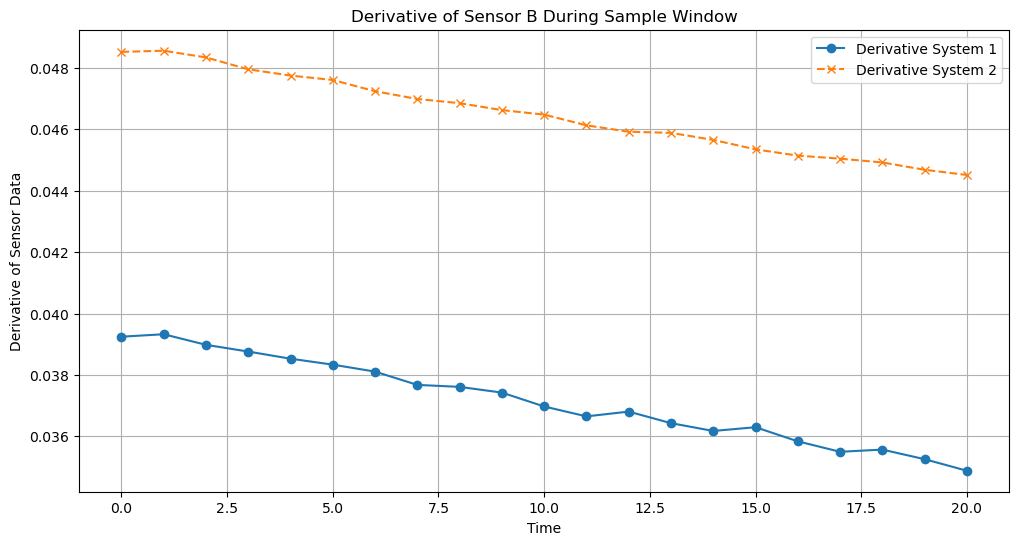

In [76]:
# Sample window derivative trend for sensor B
# Calculate the derivative of sensor data
B1_sample_window_derivative = np.gradient(B1_sample_window.mean(), B1_sample_window.columns)
B2_sample_window_derivative = np.gradient(B2_sample_window.mean(), B2_sample_window.columns)

# Plotting the derivatives
plt.figure(figsize=(12, 6))
plt.plot(B1_sample_window_derivative, label='Derivative System 1', marker='o', linestyle='-')
plt.plot(B2_sample_window_derivative, label='Derivative System 2', marker='x', linestyle='--')

plt.title('Derivative of Sensor B During Sample Window')
plt.xlabel('Time')
plt.ylabel('Derivative of Sensor Data')
plt.legend()
plt.grid(True)
plt.show()

### K-means clustering by sensor values

In [77]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# Merge system 1 and 2
A_cal_window = pd.concat([A1_cal_window, A2_cal_window])
A_sample_window = pd.concat([A1_sample_window, A2_sample_window])
B_cal_window = pd.concat([B1_cal_window, B2_cal_window])
B_sample_window = pd.concat([B1_sample_window, B2_sample_window])

# Put the beginning of all sensor data at the same value (zero)
A_cal_window_zero = A_cal_window.iloc[:, 1:].sub(A_cal_window.iloc[:, 1], axis=0)
A_sample_window_zero = A_sample_window.iloc[:, 1:].sub(A_sample_window.iloc[:, 1], axis=0)
B_cal_window_zero = B_cal_window.iloc[:, 1:].sub(B_cal_window.iloc[:, 1], axis=0)
B_sample_window_zero = B_sample_window.iloc[:, 1:].sub(B_sample_window.iloc[:, 1], axis=0)


#### Sensor A Calibration Window

/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will c

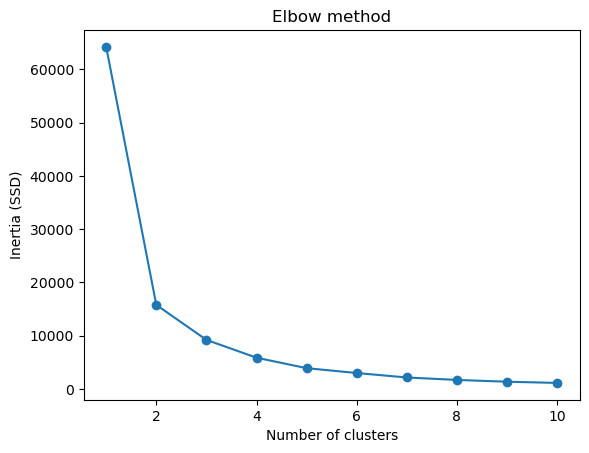

In [78]:
# Elbow Plot
inertias_cal_A = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i).fit(A_cal_window_zero)
    inertias_cal_A.append(kmeans.inertia_)

plt.plot(range(1,11), inertias_cal_A, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (SSD)')
plt.show()

In [79]:
# K-means clustering
n_clusters = 3
model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred = model_euclidean.fit_predict(A_cal_window_zero)

/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


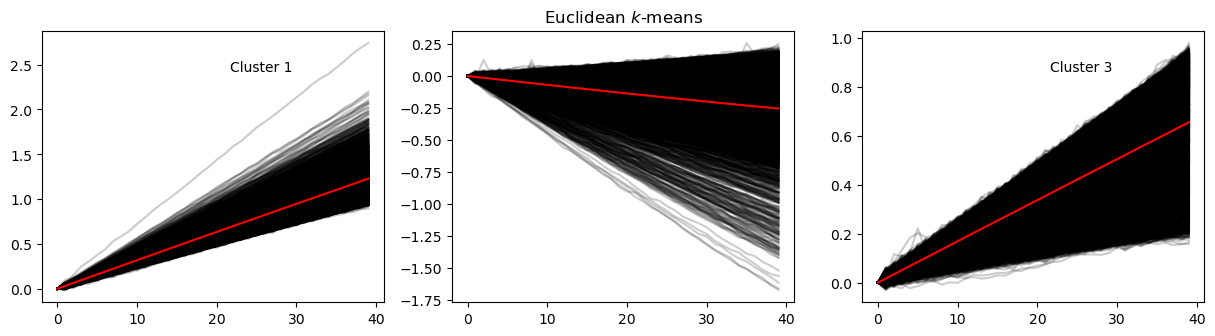

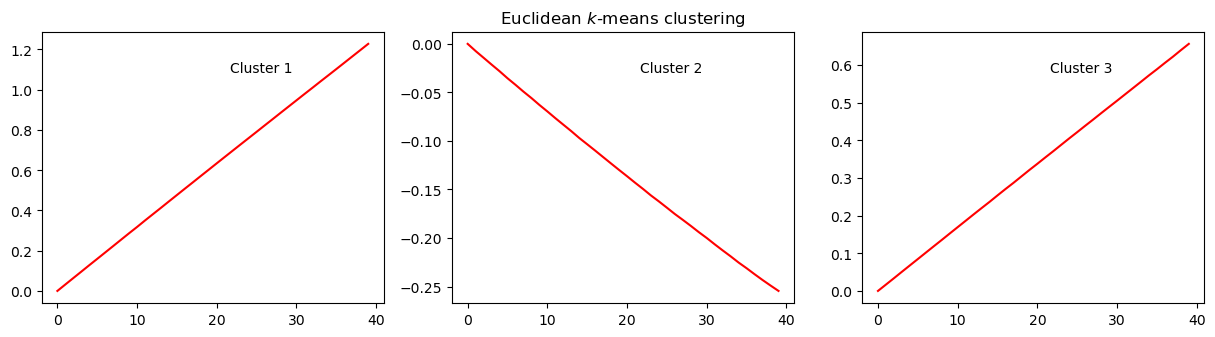

In [80]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for index, row in A_cal_window_zero[y_pred == yi].iterrows():
        plt.plot(row.ravel(), "k-", alpha=.2)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means clustering")

In [81]:
# Define a function to plot the distribution of clusters
def plot_sensor_data(window_value, y_pred):
    # Reset index and add the prediction labels
    df = window_value.reset_index()
    df['label'] = y_pred + 1
    clusters_list = np.unique(y_pred + 1)
    
    # Merge with keyByTestID
    df2 = pd.merge(keyByTestID, df[['label', 'TestID']], how='inner', on=['TestID'])
    
    # Create new columns for type and system
    df2['Type'] = df2['FluidType'].apply(lambda x: 'Eurotrol' if x.startswith('Eurotrol') else 'Blood')
    df2['Systembi'] = df2['System'].apply(lambda x: 'System 1' if x == 'System 1' else 'System 2')
    
    # Define a function to create charts for different labels
    def create_chart(df, label, column, x_title, bin_size):
        return alt.Chart(df[df['label'] == label]).mark_bar().encode(
            x=alt.X(f'{column}:Q', bin=alt.Bin(step=bin_size), title=x_title),
            y='count()'
        ).properties(width=150, height=150).facet(column=alt.Column('Systembi:N', title='')).properties(title=f'Cluster {label}')
    
    # Create charts for each label and attribute
    cardage_charts = [create_chart(df2, label, 'AgeOfCardInDaysAtTimeOfTest', 'Card Age', 28) for label in clusters_list]
    temperature_charts = [create_chart(df2, label, 'AmbientTemperature', 'Temperature', 5) for label in clusters_list]
    
    # Create charts for FluidType and Type
    fluidtype_charts = [alt.Chart(df2[df2['label'] == label]).mark_bar().encode(
            x=alt.X('FluidType:N', title='Fluid Type'),
            y='count()'
        ).properties(width=150, height=150).facet(column=alt.Column('Systembi:N', title='')).properties(title=f'Cluster {label}') for label in clusters_list]
    
    type_charts = [alt.Chart(df2[df2['label'] == label]).mark_bar().encode(
            x=alt.X('Type:N', title='Fluid Type'),
            y='count()'
        ).properties(width=150, height=150).facet(column=alt.Column('Systembi:N', title='')).properties(title=f'Cluster {label}') for label in clusters_list]
    
    # Combine the charts
    cardage_combined = alt.hconcat(*cardage_charts)
    temperature_combined = alt.hconcat(*temperature_charts)
    fluidtype_combined = alt.hconcat(*fluidtype_charts)
    type_combined = alt.hconcat(*type_charts)
    
    return (cardage_combined & temperature_combined & fluidtype_combined & type_combined)


In [82]:
# Define a visulization function for average value of each cluster
def metricsByCluster(cluster_label, window_value, y_pred):

    # Reset index and add the prediction labels
    df = window_value.reset_index()
    df['label'] = y_pred + 1
    
    # Merge with keyByTestID
    df2 = pd.merge(keyByTestID, df[['label', 'TestID']], how='inner', on=['TestID'])

    # Create new columns for type and system
    df2['Type'] = df2['FluidType'].apply(lambda x: 'Eurotrol' if x.startswith('Eurotrol') else 'Blood')
    df2['Systembi'] = df2['System'].apply(lambda x: 'System 1' if x == 'System 1' else 'System 2')

    cluster = df2[df2['label'] == cluster_label][['TestID', 'Systembi']]

    # Filtering and merging data for System 1
    cluster_data_s1 = pd.merge(cluster[cluster['Systembi'] == 'System 1']['TestID'], df, how='inner', on=['TestID']).drop("label", axis=1)
    cluster_data_s1.set_index('TestID', inplace=True)

    cluster_data_s1_mean = cluster_data_s1.mean(axis=0).to_frame().reset_index(drop=True)
    cluster_data_s1_sd = cluster_data_s1.std(axis=0).to_frame().reset_index(drop=True)
    cluster_data_s1_mean.index.name = 'Time'
    cluster_data_s1_mean.columns = ['Mean']
    cluster_data_s1_sd.columns = ['SD']
    cluster_data_s1_mean.reset_index(inplace=True)
    cluster_data_s1_sd.reset_index(inplace=True)
    #cluster_data_s1_mean['Slope'] = np.gradient(cluster_data_s1_mean['Mean'], cluster_data_s1_mean['Time'])
    cluster_data_s1_mean['Slope'] = np.abs(np.gradient(cluster_data_s1_mean['Mean'], cluster_data_s1_mean['Time']))
    cluster_data_s1_combined = pd.concat([cluster_data_s1_mean, cluster_data_s1_sd['SD']], axis=1)

    # Filtering and merging data for System 2
    cluster_data_s2 = pd.merge(cluster[cluster['Systembi'] != 'System 1']['TestID'], df, how='inner', on=['TestID']).drop("label", axis=1)
    cluster_data_s2.set_index('TestID', inplace=True)
    cluster_data_s2_mean = cluster_data_s2.mean(axis=0).to_frame().reset_index(drop=True)
    cluster_data_s2_sd = cluster_data_s2.std(axis=0).to_frame().reset_index(drop=True)
    cluster_data_s2_mean.index.name = 'Time'
    cluster_data_s2_mean.columns = ['Mean']
    cluster_data_s2_sd.columns = ['SD']
    cluster_data_s2_mean.reset_index(inplace=True)
    cluster_data_s2_sd.reset_index(inplace=True)
    # cluster_data_s2_mean['Slope'] = np.gradient(cluster_data_s2_mean['Mean'], cluster_data_s2_mean['Time'])
    cluster_data_s2_mean['Slope'] = np.abs(np.gradient(cluster_data_s2_mean['Mean'], cluster_data_s2_mean['Time']))
    cluster_data_s2_combined = pd.concat([cluster_data_s2_mean, cluster_data_s2_sd['SD']], axis=1)

    # Convert data to long format for Altair
    data_combined = pd.concat([
        cluster_data_s1_combined.assign(System='System 1'),
        cluster_data_s2_combined.assign(System='System 2')
    ])

    # Plotting the mean
    mean_chart = alt.Chart(data_combined).mark_line(point=True).encode(
        x='Time:Q',
        y='Mean:Q',
        color='System:N',
        tooltip=['Time', 'Mean', 'System']
    ).properties(
        title=f'Cluster {cluster_label} - Mean'
    )

    # Plotting the absolute slope
    slope_chart = alt.Chart(data_combined).mark_line(point=True).encode(
        x='Time:Q',
        y=alt.Y('Slope:Q', scale=alt.Scale(domain=[min(data_combined['Slope']), max(data_combined['Slope'])])),
        color='System:N',
        tooltip=['Time', 'Slope', 'System']
    ).properties(
        title=f'Cluster {cluster_label} - Slope of Mean'
    )

    # Plotting the standard deviation
    sd_chart = alt.Chart(data_combined).mark_line(point=True).encode(
        x='Time:Q',
        y='SD:Q',
        color='System:N',
        tooltip=['Time', 'SD', 'System']
    ).properties(
        title=f'Cluster {cluster_label} - Standard Deviation'
    )
    
     # Combine the charts horizontally
    combined_chart = alt.hconcat(mean_chart, slope_chart, sd_chart).resolve_scale(
        y='independent'
    )

    return combined_chart

In [83]:
def plotAllClusters(window_value, y_pred, windowType, sensorType):
    charts = []
    for cluster_label in np.unique(y_pred + 1):
        chart = metricsByCluster(cluster_label, window_value, y_pred)
        charts.append(chart)
    
    final_chart = alt.vconcat(*charts).properties(
        title=alt.TitleParams(
            f'Metrics Characterization of Sensor {sensorType} Waveforms in {windowType} Window',
            anchor='middle',
            fontSize=16
        )
    )
    
    final_chart.display()

In [84]:
# Plot the feature distribution
plot_sensor_data(A_cal_window_zero, y_pred)

alt.VConcatChart(...)

In [85]:
# Call the function to plot all clusters
plotAllClusters(A_cal_window_zero, y_pred, 'Cal','A')

alt.VConcatChart(...)

#### Sensor A Sample Window

/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will c

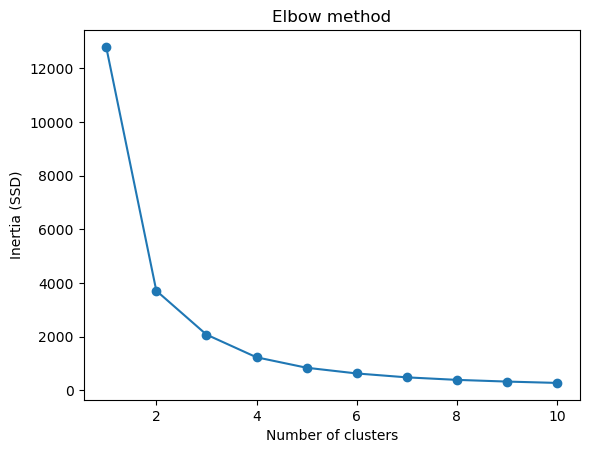

In [86]:
# Elbow Plot
inertias_sample_A = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i).fit(A_sample_window_zero)
    inertias_sample_A.append(kmeans.inertia_)

plt.plot(range(1,11), inertias_sample_A, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (SSD)')
plt.show()

In [87]:
# K-means clustering
n_clusters = 3
model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred = model_euclidean.fit_predict(A_sample_window_zero)

/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


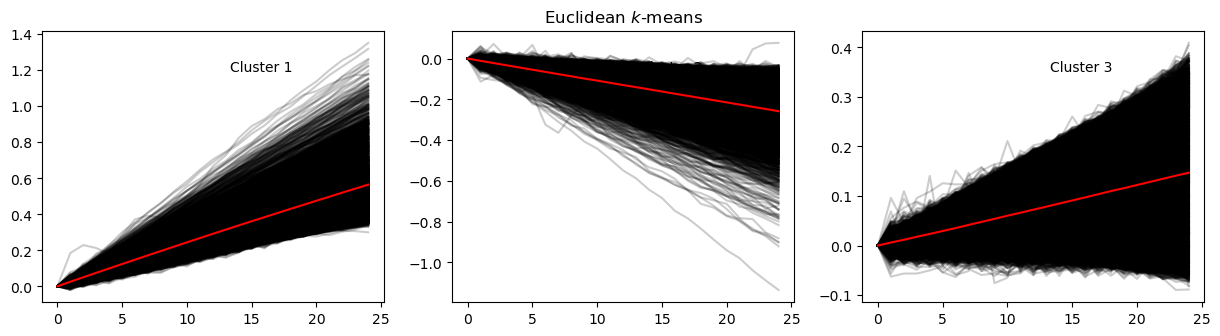

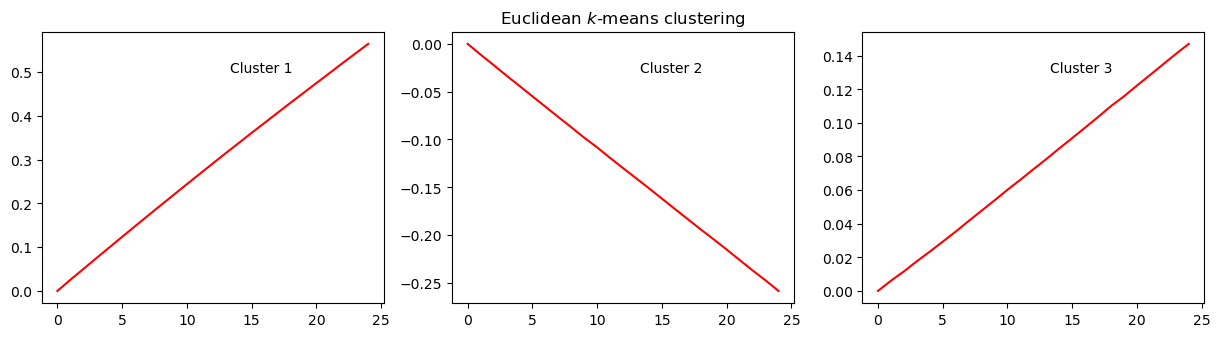

In [88]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for index, row in A_sample_window_zero[y_pred == yi].iterrows():
        plt.plot(row.ravel(), "k-", alpha=.2)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means clustering")

In [89]:
# Plot the feature distribution
plot_sensor_data(A_sample_window_zero, y_pred)

alt.VConcatChart(...)

In [90]:
# Call the function to plot all clusters
plotAllClusters(A_sample_window_zero, y_pred, 'Sample','A')


alt.VConcatChart(...)

#### Sensor B Calibration Window

/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will c

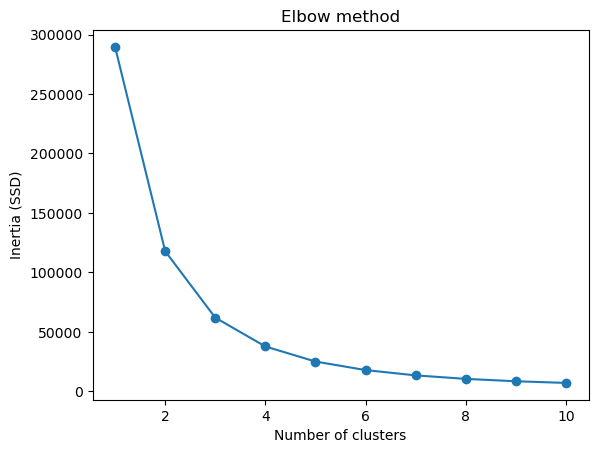

In [91]:
# Elbow Plot
inertias_cal_B = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i).fit(B_cal_window_zero)
    inertias_cal_B.append(kmeans.inertia_)

plt.plot(range(1,11), inertias_cal_B, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (SSD)')
plt.show()

In [92]:
# K-means clustering
n_clusters = 3
model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred = model_euclidean.fit_predict(B_cal_window_zero)

/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


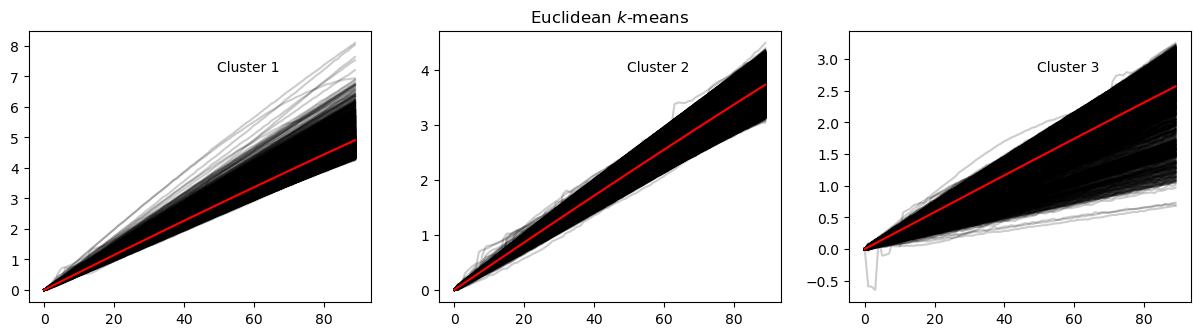

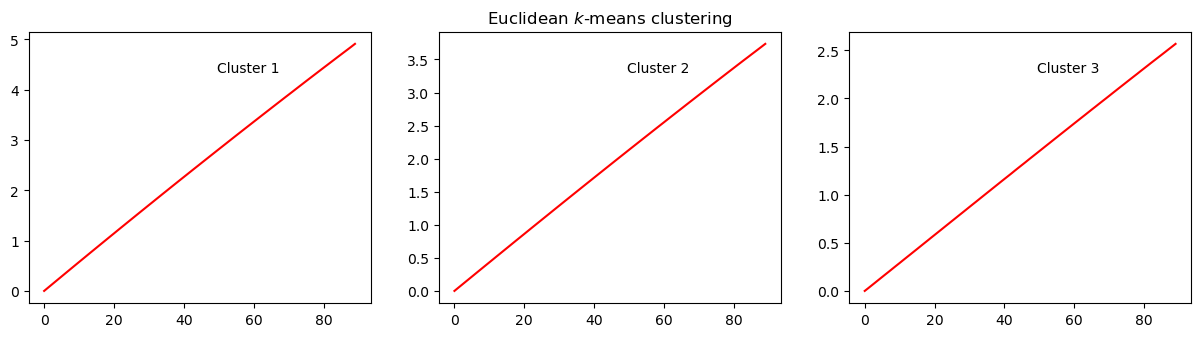

In [93]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for index, row in B_cal_window_zero[y_pred == yi].iterrows():
        plt.plot(row.ravel(), "k-", alpha=.2)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means clustering")

In [94]:
# Plot the feature distribution
plot_sensor_data(B_cal_window_zero, y_pred)

alt.VConcatChart(...)

In [95]:
plotAllClusters(B_cal_window_zero, y_pred, "Cal", "B")

alt.VConcatChart(...)

#### Sensor B Sample Window

/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will c

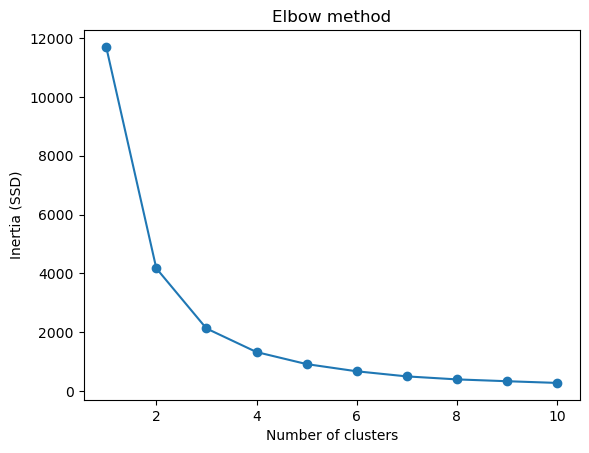

In [96]:
# Elbow Plot
inertias_sample_B = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i).fit(B_sample_window_zero)
    inertias_sample_B.append(kmeans.inertia_)

plt.plot(range(1,11), inertias_sample_B, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (SSD)')
plt.show()

In [97]:
# K-means Clustering
n_clusters = 3
model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred = model_euclidean.fit_predict(B_sample_window_zero)

/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


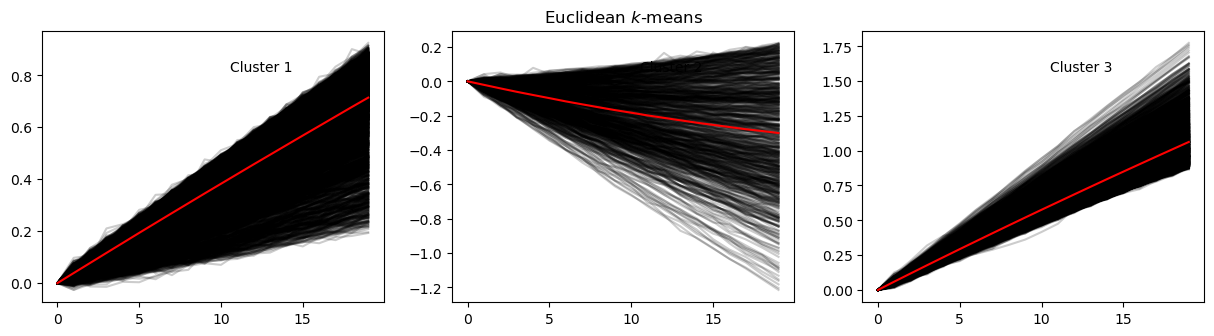

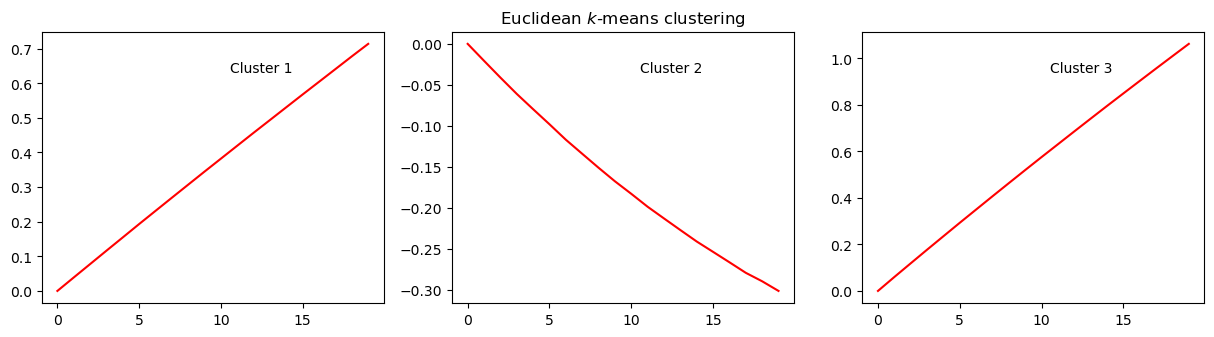

In [98]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for index, row in B_sample_window_zero[y_pred == yi].iterrows():
        plt.plot(row.ravel(), "k-", alpha=.2)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means clustering")

In [99]:
# Plot the feature distribution
plot_sensor_data(B_sample_window_zero, y_pred)

alt.VConcatChart(...)

In [100]:
plotAllClusters(B_sample_window_zero, y_pred, "Sample", "B")

alt.VConcatChart(...)

### Hierarchical clustering by sensor values

#### Sensor A Calibration Window

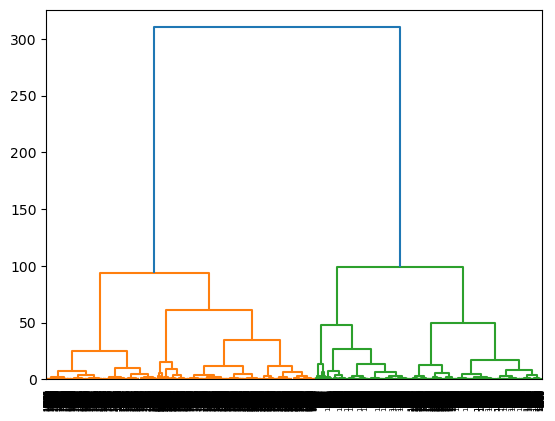

In [101]:
# Dendrogram
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
A_cal_linkage = linkage(A_cal_window_zero, method='ward', metric='euclidean')
dendrogram(A_cal_linkage)
plt.show()

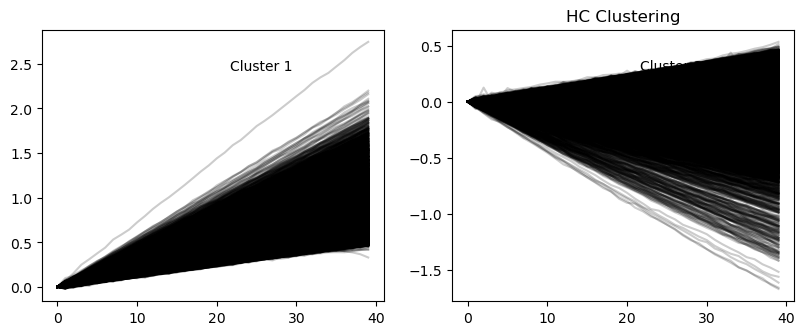

In [102]:
# Clustering and Plotting
y_pred = fcluster(A_cal_linkage, 200, criterion='distance')
n_clusters = len(np.unique(y_pred))
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for index, row in A_cal_window_zero[y_pred == yi+1].iterrows():
        plt.plot(row.ravel(), "k-", alpha=.2)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("HC Clustering")

In [103]:
# Plot the feature distribution
plot_sensor_data(A_cal_window_zero, y_pred)

alt.VConcatChart(...)

In [104]:
plotAllClusters(A_cal_window_zero, y_pred, "Cal", "A")

alt.VConcatChart(...)

#### Sensor A Sample Window

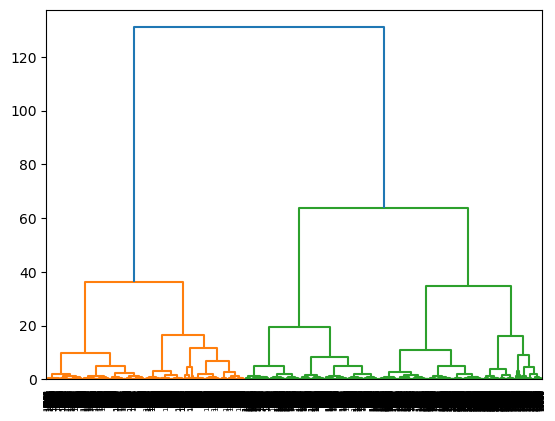

In [105]:
# Dendrogram
A_sample_linkage = linkage(A_sample_window_zero, method='ward', metric='euclidean')
dendrogram(A_sample_linkage)
plt.show()

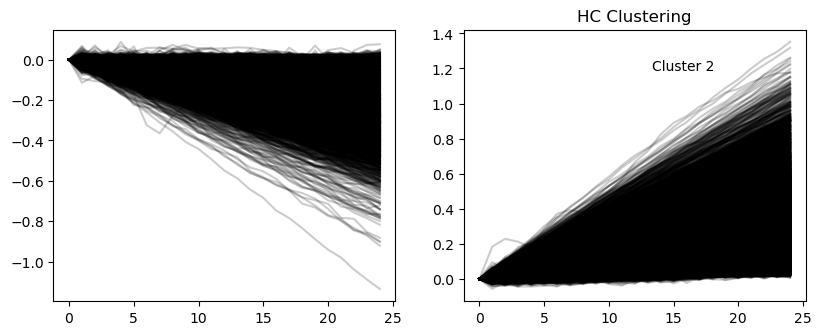

In [106]:
# Clustering and Plotting
y_pred = fcluster(A_sample_linkage, 100, criterion='distance')
n_clusters = len(np.unique(y_pred))
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for index, row in A_sample_window_zero[y_pred == yi+1].iterrows():
        plt.plot(row.ravel(), "k-", alpha=.2)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("HC Clustering")

In [107]:
# Plot the feature distribution
plot_sensor_data(A_sample_window_zero, y_pred)

alt.VConcatChart(...)

In [108]:
plotAllClusters(A_sample_window_zero, y_pred, "Sample", "A")

alt.VConcatChart(...)

#### Sensor B Calibration Window

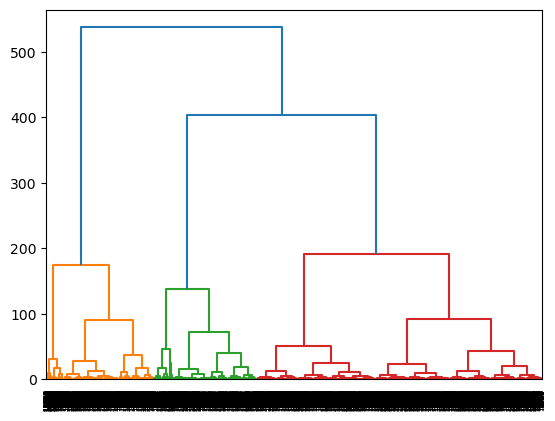

In [109]:
# Dendrogram
B_cal_linkage = linkage(B_cal_window_zero, method='ward', metric='euclidean')
dendrogram(B_cal_linkage)
plt.show()

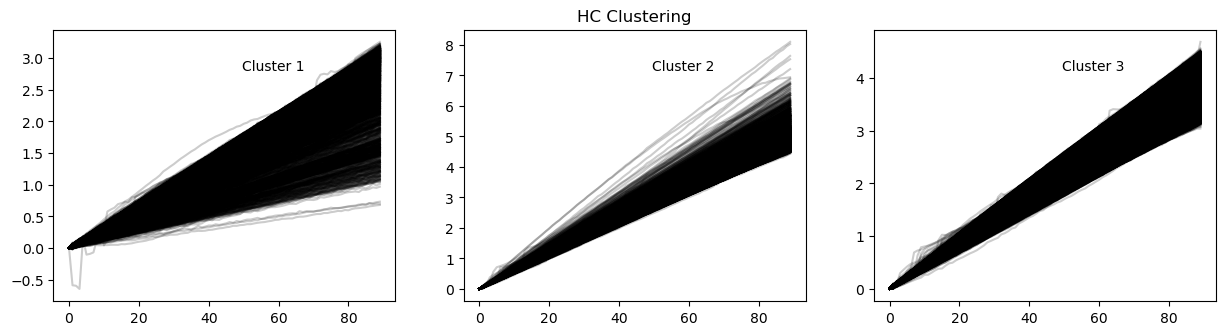

In [110]:
# Clustering and Plotting
y_pred = fcluster(B_cal_linkage, 400, criterion='distance')
n_clusters = len(np.unique(y_pred))
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for index, row in B_cal_window_zero[y_pred == yi+1].iterrows():
        plt.plot(row.ravel(), "k-", alpha=.2)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("HC Clustering")

In [111]:
# Plot the feature distribution
plot_sensor_data(B_cal_window_zero, y_pred)

alt.VConcatChart(...)

In [112]:
plotAllClusters(B_cal_window_zero, y_pred, "Cal", "B")

alt.VConcatChart(...)

#### Sensor B Sample Window

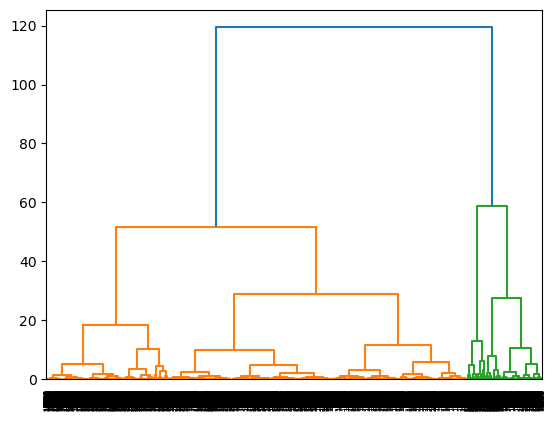

In [113]:
# sensorB sample window
B_sample_linkage = linkage(B_sample_window_zero, method='ward', metric='euclidean')
dendrogram(B_sample_linkage)
plt.show()

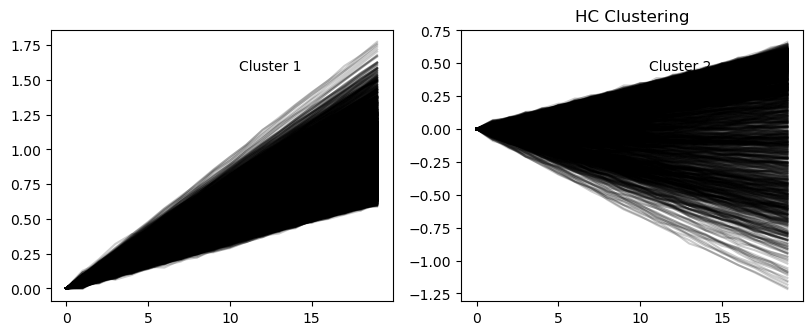

In [114]:
# Clustering and Plotting
y_pred = fcluster(B_sample_linkage, 100, criterion='distance')
n_clusters = len(np.unique(y_pred))
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for index, row in B_sample_window_zero[y_pred == yi+1].iterrows():
        plt.plot(row.ravel(), "k-", alpha=.2)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("HC Clustering")

In [115]:
# Plot the feature distribution
plot_sensor_data(B_sample_window_zero, y_pred)

alt.VConcatChart(...)

In [116]:
# Call the function to plot all clusters
plotAllClusters(B_sample_window_zero, y_pred, 'Sample','B')

alt.VConcatChart(...)